In [497]:
import pandas as pd
from pathlib import Path

# Import Data
We need to concatenate all readings from all csvs into a single DataFrame.

In [498]:
csv_files = list(Path('/content/measurements/').glob('*.csv'))
dfs = []

for csv_file in csv_files:
    df_temp = pd.read_csv(csv_file)
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)
print(f"Successfully loaded and concatenated {len(csv_files)} CSV files into a single DataFrame.")
print(f"The final DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Successfully loaded and concatenated 54 CSV files into a single DataFrame.
The final DataFrame has 1888043 rows and 5 columns.


,timestamp_iso8601,sensor,quantity,value,unit
0,2025-10-18T00:00:36Z,lm393,is_raining,0.000000,NaN
1,2025-10-18T00:00:36Z,veml7700,lux_lx,0.000000,lx
2,2025-10-18T00:00:36Z,bme280,temperature_c,27.898041,degC
3,2025-10-18T00:00:36Z,bme280,pressure_pa,101032.117188,Pa
4,2025-10-18T00:00:36Z,bme280,humidity_pct,99.317810,pct


In [499]:
df = df[["timestamp_iso8601", "quantity", "value"]]
df.head()

,timestamp_iso8601,quantity,value
0,2025-10-18T00:00:36Z,is_raining,0.000000
1,2025-10-18T00:00:36Z,lux_lx,0.000000
2,2025-10-18T00:00:36Z,temperature_c,27.898041
3,2025-10-18T00:00:36Z,pressure_pa,101032.117188
4,2025-10-18T00:00:36Z,humidity_pct,99.317810


# Data Pre-processing

## Pivoting - Reformating the data into multiple columns
We make each quantity (measurement type e.g. lux, pressure, temperature) its own column, so each row will have one value per quantity instead of one row per quantity.

In [500]:
df["quantity"].value_counts()

,count
quantity,
lux_lx,380231
is_raining,380185
pressure_pa,376197
temperature_c,375822
humidity_pct,375608


In [501]:
# Why are there different numbers of these ? or are some null ?

In [502]:
df = df.pivot_table(values='value', index='timestamp_iso8601',
                       columns='quantity', aggfunc="mean").reset_index()
print(df.columns.name)
df.head()


quantity


quantity,timestamp_iso8601,humidity_pct,is_raining,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,0.0,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,0.0,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,NaN,100961.906250,28.982277


In [503]:
df.columns.name = None

In [504]:
df = df.drop(["is_raining"], axis=1)
df.head()

,timestamp_iso8601,humidity_pct,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,100961.906250,28.982277


In [505]:
len(df)

1080215

In [506]:
df.head()

,timestamp_iso8601,humidity_pct,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,100961.906250,28.982277


In [507]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080215 entries, 0 to 1080214
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   timestamp_iso8601  1080215 non-null  object 
 1   humidity_pct       374604 non-null   float64
 2   lux_lx             379263 non-null   float64
 3   pressure_pa        375162 non-null   float64
 4   temperature_c      374830 non-null   float64
dtypes: float64(4), object(1)
memory usage: 41.2+ MB


## Resampling - Handling small gaps between sensor readings
Each quantity is captured by a different sensor. Since the data is captured every 10 seconds, there may be very slight differences (seconds or milliseconds) between when each sensor actually captures its information. This results in readings that represent the same 10 second period appear as different rows. In reality, they should represent the same instance. **Resampling** organizes the data into 30 minute chunks, and takes the average of each value within that 30 minute chunk, thus consolidating them into a single row.

In [508]:
df["timestamp_iso8601"] = pd.to_datetime(df["timestamp_iso8601"], format='mixed')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080215 entries, 0 to 1080214
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   timestamp_iso8601  1080215 non-null  datetime64[ns, UTC]
 1   humidity_pct       374604 non-null   float64            
 2   lux_lx             379263 non-null   float64            
 3   pressure_pa        375162 non-null   float64            
 4   temperature_c      374830 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 41.2 MB


In [509]:
# In the original dataset, the sensor readings may have come in at very slightly
# different times, i.e. 1 second apart. But each of these should have technically
# been one instance. So we resample, to get the average of each value within the
# specified resample time.

df = df.set_index("timestamp_iso8601").resample('30min').mean()
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615


In [510]:
len(df)

3713

In [511]:
df = df.sort_values("timestamp_iso8601")
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615


## Interpolation - Handling gaps in the continuous time data
After resampling, there would have been periods where the board was turned off. This results in gaps in the data. Interpolation uses the nearest values to the missing times to fill them.

In [512]:
df.loc["2025-09-04 22:00:00+00:00":"2025-09-05 00:00:00+00:00"]

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615


In [513]:
print(f"Data ranges from {df.index[0]} to {df.index[-1]} and we have {len(df)} instances")

Data ranges from 2025-09-04 22:00:00+00:00 to 2025-11-21 06:00:00+00:00 and we have 3713 instances


In [514]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3713 entries, 2025-09-04 22:00:00+00:00 to 2025-11-21 06:00:00+00:00
Freq: 30min
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   humidity_pct   2340 non-null   float64
 1   lux_lx         2339 non-null   float64
 2   pressure_pa    2341 non-null   float64
 3   temperature_c  2340 non-null   float64
dtypes: float64(4)
memory usage: 274.1 KB


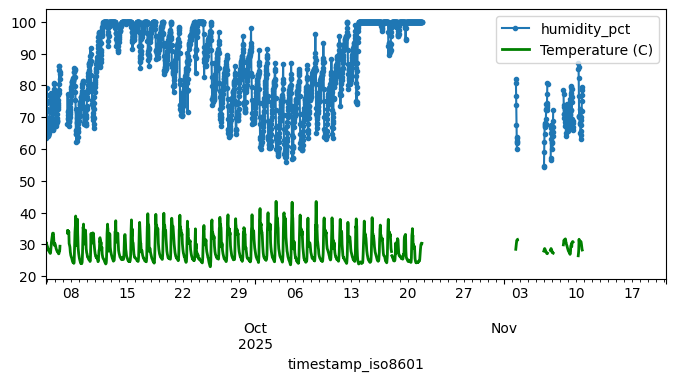

In [515]:
# Plotting
import matplotlib.pyplot as plt

# The last 5-day period
ax = df["humidity_pct"].plot(grid=True, marker='.', figsize=(8, 3.5))

df["temperature_c"].plot(
    ax=ax, color='green', linewidth=2, label="Temperature (C)"
)

# Add a legend to distinguish them
ax.legend()

In [516]:
# The gaps indicate times the board was off

In [517]:
df = df.interpolate(method="linear")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3713 entries, 2025-09-04 22:00:00+00:00 to 2025-11-21 06:00:00+00:00
Freq: 30min
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   humidity_pct   3713 non-null   float64
 1   lux_lx         3713 non-null   float64
 2   pressure_pa    3713 non-null   float64
 3   temperature_c  3713 non-null   float64
dtypes: float64(4)
memory usage: 274.1 KB


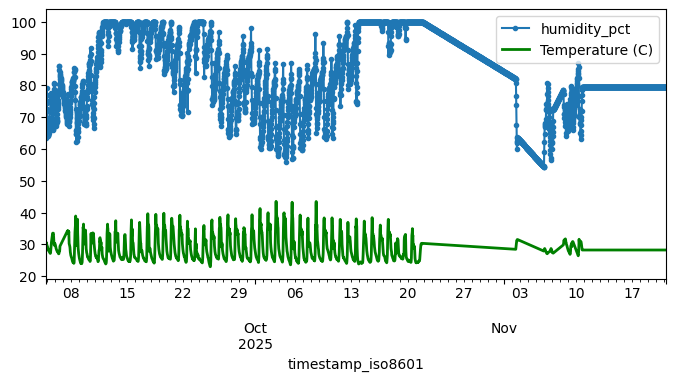

In [518]:
# The last 5-day period
ax = df["humidity_pct"].plot(grid=True, marker='.', figsize=(8, 3.5))

df["temperature_c"].plot(
    ax=ax, color='green', linewidth=2, label="Temperature (C)"
)
# Add a legend to distinguish them
ax.legend()

## Normalizing

In [519]:
df.describe()

,humidity_pct,lux_lx,pressure_pa,temperature_c
count,3713.000000,3713.000000,3713.000000,3713.000000
mean,83.864182,3168.770258,101080.316265,28.910290
std,12.113979,5621.527817,146.668056,3.242511
min,54.362780,0.000000,100635.793644,22.989888
25%,76.517198,0.000000,100982.789709,26.443921
50%,83.164870,46.306241,101094.959032,28.246843
75%,95.263119,4289.091448,101168.389773,30.167162
max,100.000000,28891.834070,101492.141722,43.539995


In [520]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[df.select_dtypes(include='number').columns] = scaler.fit_transform(
    df.select_dtypes(include='number')
)

In [521]:
df.describe()

,humidity_pct,lux_lx,pressure_pa,temperature_c
count,3.713000e+03,3.713000e+03,3.713000e+03,3.713000e+03
mean,6.889184e-16,1.530930e-17,-1.574561e-14,7.884288e-16
std,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00
min,-2.435647e+00,-5.637608e-01,-3.031216e+00,-1.826116e+00
25%,-6.065698e-01,-5.637608e-01,-6.650371e-01,-7.607378e-01
50%,-5.773548e-02,-5.555224e-01,9.984955e-02,-2.046365e-01
75%,9.411006e-01,1.993181e-01,6.005764e-01,3.876752e-01
max,1.332179e+00,4.576430e+00,2.808252e+00,4.512453e+00


## Train, Test Split

In [522]:
from sklearn.model_selection import train_test_split

# First split: 80% and 20%
df_train, df_temp = train_test_split(df, test_size=0.2,
                                     random_state=42, shuffle=False)

# Second split: split the remaining 20% into two 10% parts
df_valid, df_test = train_test_split(df_temp, test_size=0.5,
                                     random_state=42, shuffle=False)

print(f"Train: {len(df_train)}")
print(f"Valid: {len(df_valid)}")
print(f"Test: {len(df_test)}")


Train: 2970
Valid: 371
Test: 372


In [523]:
import tensorflow as tf

sample_size_in_hrs = 0.5
window_size_in_hrs = 24

seq_length = int(window_size_in_hrs / sample_size_in_hrs) # since each instance is a 30-min period, and we want a 24hr window

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    df_train.to_numpy(),
    targets=df_train["temperature_c"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_dataset = tf.keras.utils.timeseries_dataset_from_array(
    df_valid.to_numpy(),
    targets=df_valid["temperature_c"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [524]:
print(type(train_dataset))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [525]:
tf.random.set_seed(42)
rnn_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(32, input_shape=[None, 4]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [526]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10,
                                                     restore_best_weights=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

In [527]:
rnn_model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

In [528]:
rnn_history = rnn_model.fit(
    train_dataset, validation_data=valid_dataset,
    epochs=500 , callbacks=[early_stopping_cb]
)

Epoch 1/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1952 - mae: 0.4322 - val_loss: 0.0062 - val_mae: 0.0711
Epoch 2/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0200 - mae: 0.1188 - val_loss: 0.0055 - val_mae: 0.0747
Epoch 3/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0184 - mae: 0.1159 - val_loss: 0.0043 - val_mae: 0.0545
Epoch 4/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0166 - mae: 0.1089 - val_loss: 0.0044 - val_mae: 0.0546
Epoch 5/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0157 - mae: 0.1031 - val_loss: 0.0046 - val_mae: 0.0653
Epoch 6/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0153 - mae: 0.1015 - val_loss: 0.0040 - val_mae: 0.0545
Epoch 7/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0146 - mae: 0.0984 - val_loss: 0.0038 - val_mae: 0.0484
Epoch 8/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0139 - mae: 0.0966 - val_loss: 0.0037 - val_mae: 0.0513
Epoch 9/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - lo

In [529]:
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,-1.694324,-0.559029,-0.727580,-0.227572
2025-09-04 22:30:00+00:00,-1.148965,-0.556256,-0.755118,-0.173646
2025-09-04 23:00:00+00:00,-0.698928,-0.546430,-0.728030,0.514995
2025-09-04 23:30:00+00:00,-0.576005,-0.546362,-0.489817,0.434619
2025-09-05 00:00:00+00:00,-0.377663,-0.546357,-0.368732,0.254259


In [530]:
# we want to take some random 24 hour period to actually try out the model
example_set = df_valid[:seq_length]
print(len(example_set))

48


In [531]:
example_set[:5]

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-11-05 19:00:00+00:00,-2.387466,-0.553915,0.933582,-0.237650
2025-11-05 19:30:00+00:00,-2.392284,-0.553899,0.940699,-0.244766
2025-11-05 20:00:00+00:00,-2.397102,-0.553883,0.947815,-0.251883
2025-11-05 20:30:00+00:00,-2.401920,-0.553868,0.954932,-0.258999
2025-11-05 21:00:00+00:00,-2.406738,-0.553852,0.962049,-0.266115


In [532]:

import numpy as np

example_set = df_valid[:seq_length].to_numpy()  # shape (48, 5)

# Add batch dimension
example_set = np.expand_dims(example_set, axis=0)  # shape (1, 48, 5)

# Predict
prediction = rnn_model.predict(example_set)
print(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
[[-0.2848805]]


In [534]:
temp_mean = scaler.mean_[3]
temp_std = scaler.scale_[3]

print(temp_mean)
print(temp_std)

28.910289931187858
3.242074090922032


In [535]:
prediction_original = (prediction * temp_std) + temp_mean
print(prediction_original)

[[27.98668628]]


In [536]:
# Actual Value
(df_valid.iloc[seq_length+1]["temperature_c"] * temp_std) + temp_mean

np.float64(28.001624309523812)

In [537]:
(0.0969 * temp_std) + temp_mean

np.float64(29.224446910598203)

In [539]:
model_training_mae_scaled = rnn_history.history["mae"][-1]
model_training_mae_scaled

0.09437831491231918

In [540]:
mae_original = model_training_mae_scaled * temp_std
print(f"Average error in °C: {mae_original:.2f}")


Average error in °C: 0.31
